# Analyzing Amazon SageMaker Tuning results
Amazon SageMaker Automatic Model Tuning features a convenient `analytics().dataframe()` method that allows to extract all tuning job iterations with their hyperparameters and performance as a pandas dataframe. This then allows flexible analysis of the result, as shown below.

SageMaker Model Tuning is flexible and when used with custom code, allows optimization of arbitrary metrics over arbitrary parameters. Hence be aware that depending on your optimization problem, some or the function below may not apply or would require minor editing to be adapted to your problem

This notebook provide code samples demonstrating the flexible analysis capabilities enabled by SageMaker

More information can be found in related documentation:
* SageMaker Python SDK Analytics functionalities https://sagemaker.readthedocs.io/en/stable/analytics.html
* Blog Post https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/
* Official SageMaker Tuning Analytics demo: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb

In [1]:
%%sh
# freeze the Seaborn version (seaborn is a python dataviz package https://seaborn.pydata.org/)

REQUIRED_SEABORN=0.9.0
SEABORN_VERSION=$(pip freeze | grep seaborn | cut -d '=' -f 3)
if [[ "$SEABORN_VERSION" < "$REQUIRED_SEABORN" ]]; then
    echo "Seaborn version $SEABORN_VERSION found, upgrading to $REQUIRED_SEABORN"
    pip install --upgrade seaborn==0.9.0
else
    echo "Seaborn version $SEABORN_VERSION already $REQUIRED_SEABORN or later"
fi

Seaborn version 0.9.0 already 0.9.0 or later


In [2]:
%matplotlib inline

import matplotlib
import boto3
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
import sagemaker
from sagemaker.analytics import TrainingJobAnalytics
import scipy
import seaborn as sns


# instantiate a boto3 client for Cloudwatch
client = boto3.client('logs')

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 15

In [4]:
print(f'boto3 {boto3.__version__}')
print(f'matplotlib {matplotlib.__version__}')
print(f'pandas {pd.__version__}')
print(f'sagemaker {sagemaker.__version__}')
print(f'scipy {scipy.__version__}')
print(f'sns {sns.__version__}')

boto3 1.13.11
matplotlib 3.0.3
pandas 0.23.0
sagemaker 1.56.1
scipy 1.4.1
sns 0.9.0


We define a couple functions for data visualization:

In [5]:
def scatter(data, x, y, z, title, logx=False, logy=False, label=False,
               alpha=0.3, size=150):
    """
       HPO-dedicated scatterplot function
       objective is the metric to be optimized. It is encoded both by plot size 
       and plot color. Label values are manually truncated.
    """
    
    temp = data[[x,y,z]].dropna().reset_index()
    ax = temp.plot.scatter(x=x, y=y, logx=logx, logy=logy, c=z, colormap='plasma',
                          s=size*scipy.stats.rankdata(temp[z]),  # dot size inversely proportional to rank
                          alpha=alpha, colorbar=False)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    
    if label != False:
        for i in range(len(temp)):
            ax.text(temp[x][i], temp[y][i], '%s' % (int((1000*temp[label][i]))/1000),
                    zorder=1, color='k')
    return ax

            
            
def surface_plot(x, y, z, xlabel, ylabel):
    """3D surface of z as a function of x and y.
       x, y and z provided as numpy or pandas 1D-arrays"""
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    viz = ax.plot_trisurf(x, y, z, cmap=cm.plasma, linewidth=0.1, antialiased=True)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlim(z.min(), z.max())
    
    fig.colorbar(viz, shrink=0.5, aspect=5)
    
    plt.show()

### Bring SageMaker Tuning results

<font color="brown"> **Edit the cell below to collect information for any running or completed hyperparameter tuning job. You can check the available jobs in the [AWS console](https://eu-west-1.console.aws.amazon.com/sagemaker/home?region=eu-west-1#/hyper-tuning-jobs/)] (set the correct region). You can also browse them with the SDK of your choice.**
</font>

In [6]:
%store -r tuning_job_name

In [7]:
print('Previous Tuning Job Name: {}'.format(tuning_job_name))

Previous Tuning Job Name: tensorflow-training-200612-1046


In [8]:
jobname = tuning_job_name

In [9]:
tuner = sagemaker.tuner.HyperparameterTuner.attach(jobname)

# define a boolean that will be used to sort the data in the right order, depending on the tuning direction:
if tuner.objective_type == 'Maximize':
    is_ascending = True
elif tuner.objective_type == 'Minimize':
    is_ascending = False
    
print('for this tuner, objective is to ' + tuner.objective_type)

for this tuner, objective is to Maximize


In [10]:
results = tuner.analytics().dataframe()

# Only use completed training jobs
results = results[results.TrainingJobStatus == "Completed"]
num_iterations = results.shape[0]

if (num_iterations >= 1):
    
    # sort
    results = (results[~results.FinalObjectiveValue.isnull()]
               .sort_values(by='TrainingStartTime', ascending=True).reset_index(drop=True))

    # best job so far
    if is_ascending:
        results['cumulative'] = results['FinalObjectiveValue'].cummax()
    else:
        results['cumulative'] = results['FinalObjectiveValue'].cummin()

    best_job = results.sort_values(by='FinalObjectiveValue',
                                   ascending=not is_ascending)['TrainingJobName'].values[0]
    print('{} iterations'.format(len(results)))
    print('best job: {}'.format(best_job))

    # show top 5 best iterations
    print(results.sort_values(by='FinalObjectiveValue', ascending=not is_ascending).head(5))
else:
    print(f'Job {jobname} has no tuning results to analyze yet.')

2 iterations
best job: tensorflow-training-200612-1046-001-d6feee4c
   FinalObjectiveValue  TrainingElapsedTimeSeconds           TrainingEndTime  \
0                 0.25                      2069.0 2020-06-12 11:22:57+00:00   
1                 0.25                      2139.0 2020-06-12 12:06:31+00:00   

                                TrainingJobName TrainingJobStatus  \
0  tensorflow-training-200612-1046-001-d6feee4c         Completed   
1  tensorflow-training-200612-1046-002-cc196201         Completed   

          TrainingStartTime       epsilon  learning_rate  cumulative  
0 2020-06-12 10:48:28+00:00  1.392559e-08       0.000048        0.25  
1 2020-06-12 11:30:52+00:00  5.685460e-08       0.000018        0.25  


### Convergence speed

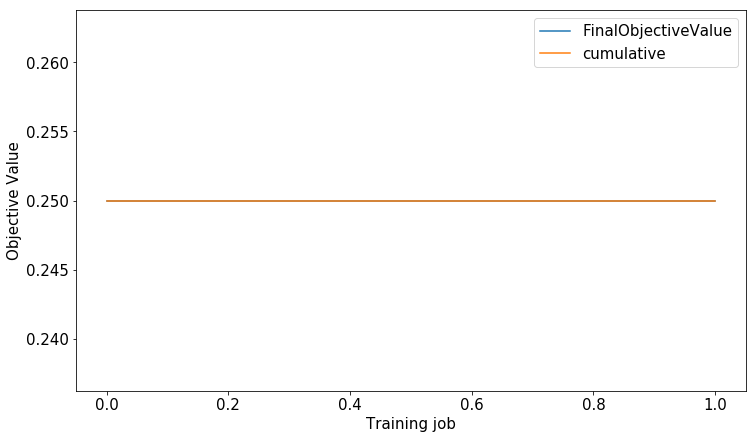

In [11]:
# target vs iteration

ax = (results.sort_values(by='TrainingStartTime', ascending=True)
 .reset_index()[['FinalObjectiveValue', 'cumulative']].plot())
ax.set_xlabel('Training job')
ax.set_ylabel('Objective Value');

This allows us to display epoch-by-epoch performance of all iterations and highlight the best iteration

### Analyze continous hyperparameters

<font color="brown"> **Make sure to use variables that were actually tuned in your specific tuning job for `x` and `y` below. Also check if `logx` and `logy` make sense for the parameters you're analyzing. Depending on the number of points, a higher alpha may be a good idea as well.**</font>

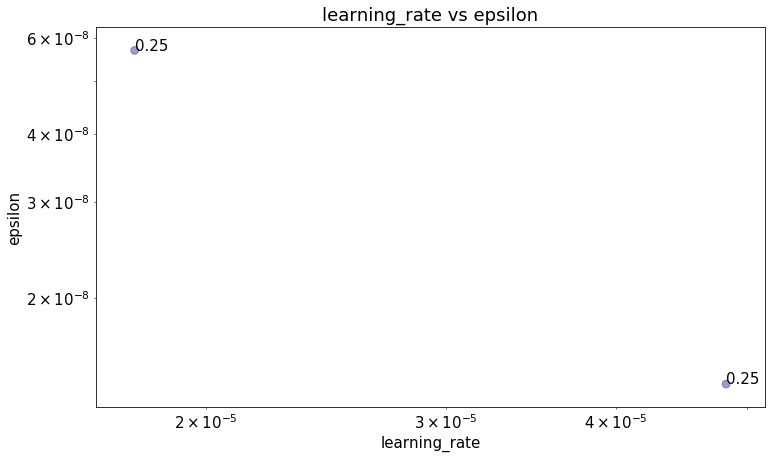

In [12]:
x = 'learning_rate'
y = 'epsilon'
z = 'FinalObjectiveValue'

scatter(data=results, x=x, y=y, z=z, title=x+' vs '+y, logx=True, logy=True, label=z, alpha=0.4, size=40);

In [13]:
if (np.min([results[x].size, results[y].size]) >= 3):

    surface_plot(x=results[x], y=results[y], z=results[z], xlabel=x, ylabel=y)
else:
    print('Not enough iterations to generate plot (need at least three).')

Not enough iterations to generate plot (need at least three).


### Analyze categorical hyperparameters

In [14]:
sns.boxplot(x='FinalObjectiveValue', y='optimizer', data=results);

ValueError: Could not interpret input 'optimizer'

### Get per-training job metric data
We use the very convenient `TrainingJobAnalytics` from the SageMaker Python SDK to gather metrics collected by individual training jobs.

<font color="brown"> **SageMaker Cloudwatch metrics are stored for 2 weeks. This part of the analytics can only be run less than 2 weeks after the hyperparameter tuning job ran**
</font>



In [15]:
def job_metric(jobname, metric_name):
    jobdf = TrainingJobAnalytics(
        training_job_name=jobname,
        metric_names=[metric_name]).dataframe()
    
    jobdf['TrainingJobName'] = [jobname]*len(jobdf)
    
    return jobdf

In [16]:
print('Pick one of the following metrics for the next cell:')

samplejob = TrainingJobAnalytics(training_job_name=results['TrainingJobName'][0])
metrics = samplejob.dataframe()['metric_name'].unique()
print('\n'.join([f'   - {metric}' for metric in metrics if metric != 'ObjectiveMetric']))

Pick one of the following metrics for the next cell:
   - train:loss
   - train:accuracy
   - validation:loss
   - validation:accuracy


In [18]:
allmetrics = pd.concat([job_metric(job, 'validation:accuracy') for job in results['TrainingJobName']])

In [19]:
allmetrics.sort_values(by='value', ascending=not is_ascending).head()

,timestamp,metric_name,value,TrainingJobName
0,0.0,validation:accuracy,0.25,tensorflow-training-200612-1046-001-d6feee4c
1,240.0,validation:accuracy,0.25,tensorflow-training-200612-1046-001-d6feee4c
0,0.0,validation:accuracy,0.25,tensorflow-training-200612-1046-002-cc196201
1,240.0,validation:accuracy,0.25,tensorflow-training-200612-1046-002-cc196201


In [20]:
# add an "Is_best" marker
allmetrics = pd.merge(allmetrics, results[['TrainingJobName', 'FinalObjectiveValue']], on='TrainingJobName')
allmetrics['is_best'] = [1 if j == best_job else 0 for j in allmetrics['TrainingJobName']]

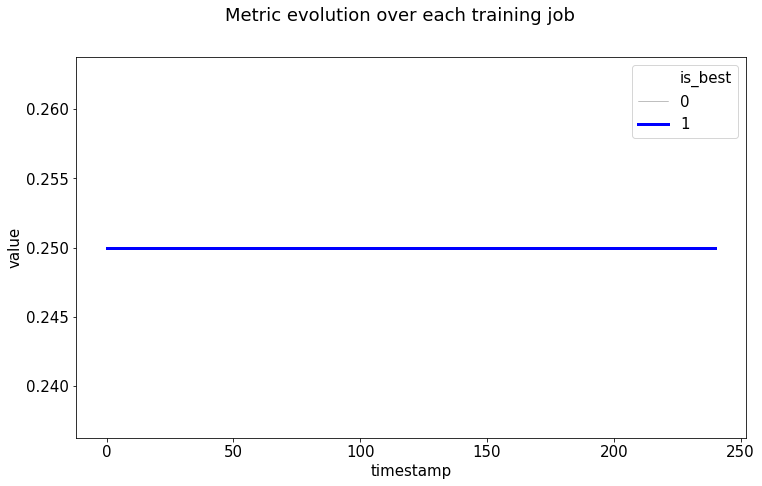

In [21]:
sns.lineplot(x='timestamp',
             y='value',
             data=allmetrics,
             units='TrainingJobName',
             estimator=None,
             size='is_best',
             sizes=(3, 0.5),
             palette=['gray', 'blue'],
             hue='is_best',).figure.suptitle('Metric evolution over each training job');

The graph above shows how the tuned hyperparameters yield superior performance, as evidenced by the slope of the best training job.